![text](header.png)

### MLP-based model training 

#### Libraries

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-04-02 17:45:48.169348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


#### Enable GPU 

In [2]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


2025-04-02 17:45:48.990455: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-04-02 17:45:49.070577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 17:45:49.070727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 with Max-Q Design computeCapability: 7.5
coreClock: 1.155GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 149.04GiB/s
2025-04-02 17:45:49.070775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-04-02 17:45:49.072525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-04-02 17:45:49.072640: I tensorflow/s

#### Load dataset

In [3]:
# Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0          


#### Fashion MNIST: classes

| Label | Class |  
|-----------|-----------|
|0  | T-shirt/top	   |
|1	|Trouser    |
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag	|
|9	|Ankle boot|

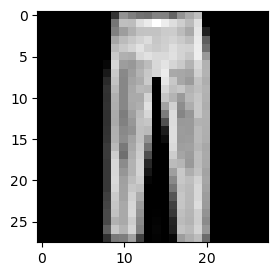

In [14]:
# Image index

N = 16

plt.figure(figsize=(3,3))
plt.imshow(x_train[N], cmap='gray')

In [5]:
# Labels
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Model definition



In [6]:
# MLP architecture

w = 28
h = 28
n_classes = 10

model= Sequential([

    Flatten(input_shape=(w, h)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')

])


2025-04-02 17:45:49.619271: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-02 17:45:49.650438: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304000000 Hz
2025-04-02 17:45:49.650983: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6b431d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-02 17:45:49.651014: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-02 17:45:49.709066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retu

### Build model

In [ ]:
lr = 0.001
# op = Adam(lr)
op = SGD(lr)

model.compile(loss='sparse_categorical_crossentropy', optimizer=op, metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
__________________________________________________

### Model training

In [9]:
history = model.fit(x_train_norm, y_train, epochs= 32, batch_size = 50, validation_split=0.2)

2025-04-02 17:46:00.884570: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-04-02 17:46:01.063809: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epoch 1/32
960/960 [==============================] - 1s 1ms/step - loss: 2.1780 - accuracy: 0.2429 - val_loss: 1.6307 - val_accuracy: 0.5069
Epoch 2/32
960/960 [==============================] - 1s 829us/step - loss: 1.5331 - accuracy: 0.5208 - val_loss: 1.0964 - val_accuracy: 0.6637
Epoch 3/32
960/960 [==============================] - 1s 835us/step - loss: 1.1021 - accuracy: 0.6399 - val_loss: 0.8642 - val_accuracy: 0.7070
Epoch 4/32
960/960 [==============================] - 1s 801us/step - loss: 0.9071 - accuracy: 0.6869 - val_loss: 0.7655 - val_accuracy: 0.7437
Epoch 5/32
960/960 [==============================] - 1s 932us/step - loss: 0.8152 - accuracy: 0.7186 - val_loss: 0.7089 - val_accuracy: 0.7564
Epoch 6/32
960/960 [==============================] - 1s 977us/step - loss: 0.7522 - accuracy: 0.7380 - val_loss: 0.6678 - val_accuracy: 0.7696
Epoch 7/32
960/960 [==============================] - 1s 818us/step - loss: 0.7155 - accuracy: 0.7511 - val_loss: 0.6377 - val_accuracy: 0

In [10]:
# Model evaluation
test_loss, test_acc = model.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 [==============================] - 0s 913us/step - loss: 0.4655 - accuracy: 0.8359

Test accuracy: 0.8359


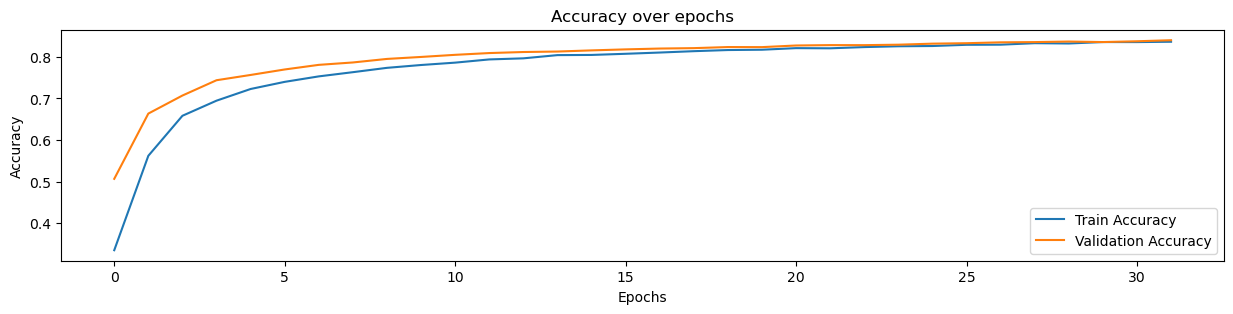

In [11]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

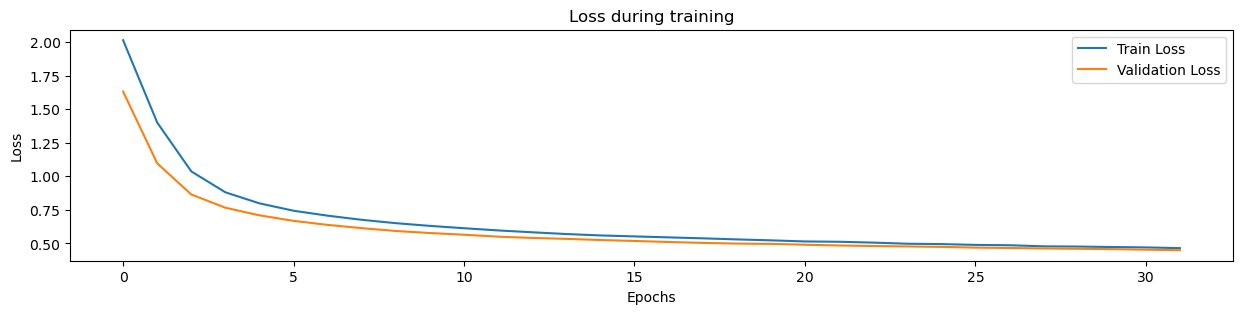

In [12]:
# Plot accuracy over loss
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

### Inference test

Predicted Class: 43241 - True label: 7


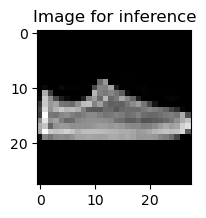

In [16]:

index = 12

plt.figure(figsize=(2,2))
plt.imshow(x_test[index], cmap='gray')
plt.title("Image for inference")

# x_test_norm_reshaped = x_test[index].reshape(-1, 28*28)

y_pred = model.predict(x_test_norm)

y_pred = np.argmax(y_pred) 
print(f"Predicted Class: {y_pred} - True label: {y_test[index]}")

### Confusion Matrix

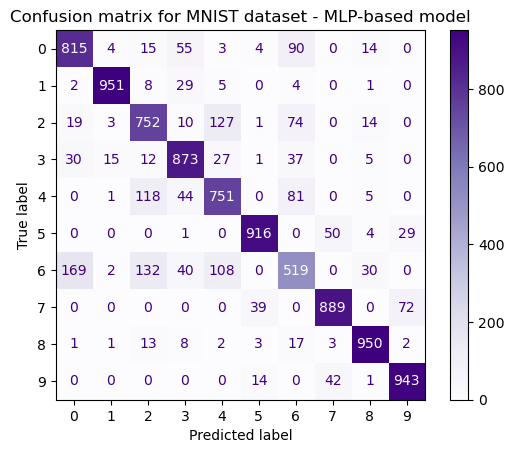

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score


y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Purples')
plt.title('Confusion matrix for MNIST dataset - MLP-based model')
plt.show()

In [ ]:
model.save("fashionMNIST.h5")

---
#### Mar del Plata, Argentina - 2025

Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy